     - Since Transaction amount is not the best feature to use for z_score anomly detection, as every user have different behaviour and amount, we need to look for other features in the data.
     
     - The data by itself do not have alot of features, yet we can use Long and Lat for detecting anomalies. If a user did a transaction in a location that is not near the location where he usually make transaction from, it should arise a flag for investigation (that is typical for logging in from another device messages).
     
     - However, since the geolocations are different for every user in the data-set, and unusal location for one user maybe usual for other users this will not be detected if we took the mean and std across the data-set, therefore I went with the approach  implemented in this notebook.
     
     - I am not sure of the feasibility of this approach in production, but with investigating the results and some googling, it should work.
     
     - The approach:
         1- Engineer new feature that may seem relevant in introducing new patterns.
         2- Apply dimensionality reduction.
         3- calculate z_score for the dimensionality reduced data.
         4- Flag those transactions that exceeds the z_score Thresholds.

# Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import calendar
import random
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')
# visualization basic configuration
%matplotlib inline
base_color = sb.color_palette()[0]
standard = [14.70, 8.27]
panorama = [20,8.27]

plt.rcParams.update({'font.size': 22})

# Loading data

In [4]:
trans = pd.read_csv('./transactions.csv')
cc = pd.read_csv('cc_info.csv')

In [5]:
trans.head(3)

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004


In [100]:
cc.head(3)

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000


## Join the tables

In [168]:
df = pd.merge(
        trans,
        cc,
        how = "inner",
         on = 'credit_card')
df.head(3)

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000


# Feature Engineering

These features may help introducing patterns in the way the users buying habits.

In [169]:
df['date'] = pd.to_datetime(df['date'],  errors = 'coerce')
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day
df['time'] = pd.to_datetime(df['date']).dt.time
df['day_of_week'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour
df['is_weekend'] = np.where(df['day_of_week'].isin(['Saturday','Sunday']),1,0)

df.head(3)

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,year,month,day,time,day_of_week,hour,is_weekend
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,2015,9,11,00:32:40,Friday,0,0
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,2015,10,24,22:23:08,Saturday,22,1
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,2015,10,26,18:19:36,Monday,18,0


In [170]:
from sklearn import preprocessing
le_city = preprocessing.LabelEncoder()
le_state = preprocessing.LabelEncoder()
le_day_of_week = preprocessing.LabelEncoder()
le_day_part = preprocessing.LabelEncoder()

In [172]:
X = df.drop(columns={'date','time'})
X['city'] = le_city.fit_transform(X['city'])
X['state'] = le_state.fit_transform(X['state'])
X['day_of_week'] = le_day_of_week.fit_transform(X['day_of_week'])

X.head(3)

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,year,month,day,day_of_week,hour,is_weekend
0,1003715054175576,43.78,-80.174132,40.267370,50,26,15342,20000,2015,9,11,0,0,0
1,1003715054175576,103.15,-80.194240,40.180114,50,26,15342,20000,2015,10,24,2,22,1
2,1003715054175576,48.55,-80.211033,40.313004,50,26,15342,20000,2015,10,26,1,18,0


since we don't need the credit card as a feature we will drop it

In [173]:
X = X.drop(columns=['credit_card'])

In [174]:
X.head(3)

,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,year,month,day,day_of_week,hour,is_weekend
0,43.78,-80.174132,40.267370,50,26,15342,20000,2015,9,11,0,0,0
1,103.15,-80.194240,40.180114,50,26,15342,20000,2015,10,24,2,22,1
2,48.55,-80.211033,40.313004,50,26,15342,20000,2015,10,26,1,18,0


# Standardization and dimensionality reduction.

In [175]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [176]:
X_scaled.shape

(294588, 13)

In [236]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

In [237]:
pca.explained_variance_ratio_

array([0.15484876, 0.0996857 , 0.09807471, 0.09437799, 0.09110787,
       0.08659689, 0.08130048, 0.07291739, 0.07002346, 0.06770654])

In [238]:
np.sum(pca.explained_variance_ratio_)

0.9166397754400131

In [239]:
X_pca = X_pca.squeeze()

In [240]:
from scipy.stats import zscore
X_z  = np.abs(zscore(X_pca))

In [241]:
X_z = X_z.mean(axis=1)

In [242]:
X_out = (X_z > 3)

In [243]:
X_out.sum()

135

In [244]:
df['outlier'] = X_out

In [245]:
inl = df[df['outlier'] == False]
out = df[df['outlier'] == True]

In [246]:
inl.shape, out.shape

((294453, 17), (135, 17))

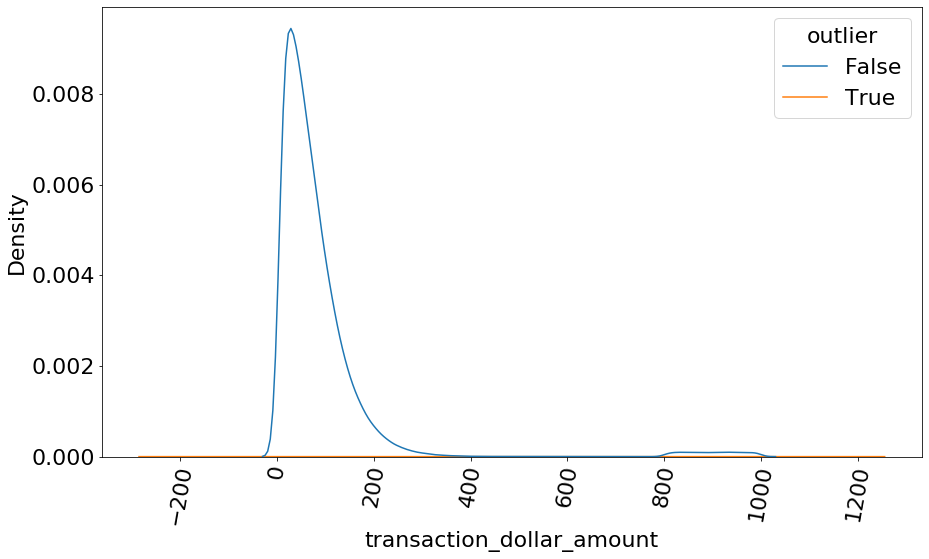

In [247]:
plt.figure(figsize = standard)
sb.kdeplot(x = df['transaction_dollar_amount'], hue=df['outlier'] ,color = base_color)
plt.xticks(rotation = 80);

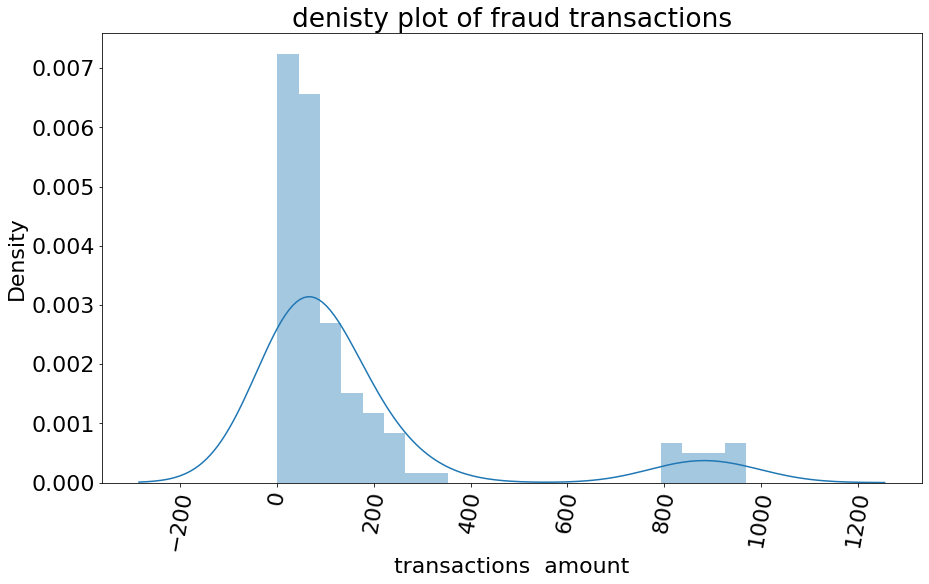

In [248]:
plt.figure(figsize = standard)
plt.title('denisty plot of fraud transactions')
plt.xlabel('transactions  amount')
sb.distplot(x = out['transaction_dollar_amount'], color = base_color)
plt.xticks(rotation = 80);

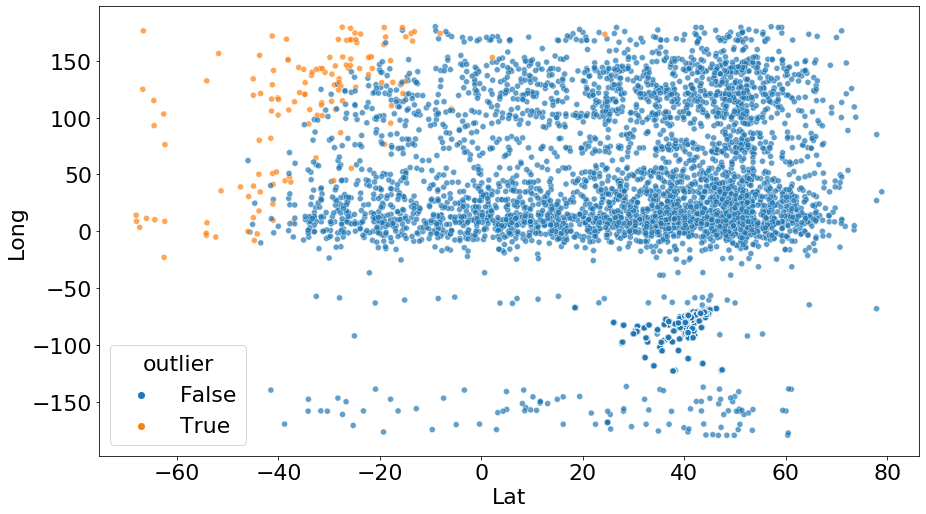

In [250]:
plt.figure(figsize = standard)
plt.xlabel('Lat')
sb.scatterplot(x = df['Lat'], y = df['Long'], hue = df['outlier'], alpha = 0.7)

## challenges

    1- what new features could help
    2- how many principle compenents to take --> up to k components that could explain at least 90% of variance in the data
    3- how to deal with z_score for each featrue --> take their mean --> I am not sure about this step, but the first idea came to mind, maybe we can discuss this one.
         - what other approaches: 
             - flag as outlier if the z_score exceeded the threshold in any of the principle components.